In [16]:
# --- 核心库 ---
import cdsapi
import logging
import xarray as xr
from pathlib import Path
from datetime import datetime, timezone, date
from zoneinfo import ZoneInfo
from typing import Dict, Set, List, Literal
import zipfile
import io
import pandas as pd
import matplotlib.pyplot as plt

# --- 项目模块 ---
from chromasky_toolkit import config
from chromasky_toolkit.map_drawer import generate_map_from_grid
from IPython.display import display, Image

# --- 日志设置 ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger("PastDataPipeline")

print("✅ 环境设置与导入完成。")

✅ 环境设置与导入完成。


In [17]:
# ======================================================================
# --- 核心配置区：请在此处设置您的目标参数 ---
# ======================================================================

# 1. 设置您想分析的本地日期
TARGET_LOCAL_DATE_STR = "2025-07-18"

# 2. 设置您想分析的天文事件 ('sunrise' 或 'sunset')
#    这将决定下载哪些小时的数据。
EVENT_TYPE: Literal["sunrise", "sunset"] = "sunset"

In [18]:
def get_required_utc_times(target_local_date: date, event: Literal["sunrise", "sunset"]) -> Dict[str, Set[int]]:
    """根据目标本地日期和指定的事件，计算出需要下载的UTC日期和小时。"""
    local_tz = ZoneInfo(config.LOCAL_TZ)
    # 根据事件类型选择对应的时间列表
    event_times_config = config.SUNRISE_EVENT_TIMES if event == "sunrise" else config.SUNSET_EVENT_TIMES
    
    utc_date_hours: Dict[str, Set[int]] = {}
    logger.info(f"为本地日期 {target_local_date} 的 {event} 事件计算所需的 UTC 时间...")
    
    for time_str in event_times_config:
        local_dt = datetime.combine(target_local_date, datetime.strptime(time_str, '%H:%M').time(), tzinfo=local_tz)
        utc_dt = local_dt.astimezone(timezone.utc)
        utc_date_str = utc_dt.strftime('%Y-%m-%d')
        if utc_date_str not in utc_date_hours:
            utc_date_hours[utc_date_str] = set()
        utc_date_hours[utc_date_str].add(utc_dt.hour)
            
    logger.info(f"计算完成的 UTC 请求信息: {utc_date_hours}")
    return utc_date_hours


def download_era5_data_for_event(target_local_date: date, event: Literal["sunrise", "sunset"]) -> Path | None:
    """为指定的本地日期和事件下载 ERA5 再分析数据。"""
    if not config.CDS_API_KEY:
        logger.error("❌ CDS API 配置未找到，无法继续下载。")
        return None

    # 文件名现在包含事件类型，例如 era5_data_sunset.nc
    output_dir = config.ERA5_DATA_DIR / target_local_date.strftime('%Y-%m-%d')
    output_dir.mkdir(parents=True, exist_ok=True)
    final_output_file = output_dir / f"era5_data_{event}.nc"
    
    if final_output_file.exists():
        logger.info(f"✅ 最终文件 '{final_output_file.name}' 已存在，跳过下载。")
        return final_output_file

    required_utc_info = get_required_utc_times(target_local_date, event)
    if not required_utc_info:
        logger.warning("未能计算出任何需要下载的UTC日期和小时。")
        return None

    # ... (构建 request_params 的逻辑保持不变)
    years, months, days, hours = set(), set(), set(), set()
    for utc_date_str, hours_set in required_utc_info.items():
        dt_obj = datetime.strptime(utc_date_str, '%Y-%m-%d'); years.add(f"{dt_obj.year}"); months.add(f"{dt_obj.month:02d}"); days.add(f"{dt_obj.day:02d}")
        hours.update([f"{h:02d}:00" for h in hours_set])
    request_params = {'year': sorted(list(years)), 'month': sorted(list(months)), 'day': sorted(list(days)), 'time': sorted(list(hours))}
    
    logger.info(f"将为 {event} 事件发起下载请求: {request_params}")

    c = cdsapi.Client(timeout=600, quiet=False, url="https://cds.climate.copernicus.eu/api", key=config.CDS_API_KEY)
    temp_download_path = output_dir / f"temp_download_{event}"
    
    try:
        c.retrieve(
            'reanalysis-era5-single-levels',
            {
                'product_type': 'reanalysis', 'format': 'netcdf',
                'variable': ["high_cloud_cover", "medium_cloud_cover", "low_cloud_cover", "total_cloud_cover"],
                'area': [config.AREA_EXTRACTION[k] for k in ["north", "west", "south", "east"]],
                **request_params
            },
            str(temp_download_path)
        )
        logger.info(f"✅ 临时文件已成功下载到: {temp_download_path}")

        # ... (处理 ZIP 文件的逻辑保持不变)
        if zipfile.is_zipfile(temp_download_path):
            with zipfile.ZipFile(temp_download_path, 'r') as z:
                nc_file = [f for f in z.namelist() if f.endswith('.nc')][0]
                source_path = Path(z.extract(nc_file, path=output_dir))
                source_path.rename(final_output_file)
        else:
            temp_download_path.rename(final_output_file)
        
        return final_output_file
    except Exception as e:
        logger.error(f"❌ 下载或处理时发生错误: {e}", exc_info=True)
        return None
    finally:
        if temp_download_path.exists(): temp_download_path.unlink()


def extract_and_save_all_slices(source_nc_path: Path, variables: List[str]) -> List[Path]:
    """
    从大的 NetCDF 文件中，为所有时间和所有指定变量提取数据切片并保存。
    *** 新版本：使用本地时区来命名输出文件。***
    """
    if not source_nc_path.exists():
        logger.error(f"❌ 源文件不存在: {source_nc_path}")
        return []

    saved_paths = []
    local_tz = ZoneInfo(config.LOCAL_TZ) # 获取本地时区对象

    with xr.open_dataset(source_nc_path, engine="netcdf4") as ds:
        time_coord_name = 'valid_time' if 'valid_time' in ds.coords else 'time'
        time_coord = ds[time_coord_name]
        
        logger.info(f"将使用 '{config.LOCAL_TZ}' 时区进行文件名转换。")
        
        for utc_dt_numpy in time_coord.values:
            # 1. 将 numpy.datetime64 转换为带 UTC 时区的 Python datetime 对象
            utc_dt = pd.to_datetime(utc_dt_numpy).to_pydatetime().replace(tzinfo=timezone.utc)
            
            # 2. 将 UTC 时间转换为本地时间
            local_dt = utc_dt.astimezone(local_tz)
            
            # 3. 使用本地时间构建输出路径和文件名
            local_date_str = local_dt.strftime('%Y-%m-%d')
            local_time_str_path = local_dt.strftime('%H%M')
            
            for var in variables:
                try:
                    # 使用原始的 UTC 时间进行数据切片
                    data_slice = ds[var].sel({time_coord_name: utc_dt_numpy}, method='nearest')
                    
                    # 使用本地时间构建输出目录和文件名
                    output_dir = config.PROCESSED_DATA_DIR / "past" / local_date_str
                    output_dir.mkdir(parents=True, exist_ok=True)
                    output_path = output_dir / f"{var}_{local_time_str_path}.nc"
                    
                    # 添加元数据到文件，记录原始UTC时间
                    data_slice.attrs['original_utc_time'] = utc_dt.isoformat()
                    
                    data_slice.to_netcdf(output_path)
                    
                    # 日志中同时显示UTC和本地时间，方便追溯
                    log_msg = (
                        f"✅ 数据切片 [{var}] "
                        f"(UTC: {utc_dt.strftime('%H:%M')} -> Local: {local_dt.strftime('%H:%M')}) "
                        f"已保存到: {output_path.relative_to(config.PROJECT_ROOT)}"
                    )
                    logger.info(log_msg)
                    saved_paths.append(output_path)
                    
                except Exception as e:
                    logger.error(f"❌ 提取或保存 {var} @ {utc_dt.strftime('%H:%M')} UTC 时出错: {e}")
    return saved_paths

In [19]:
# --- 1. 根据配置解析参数 ---
target_date = datetime.strptime(TARGET_LOCAL_DATE_STR, "%Y-%m-%d").date()
variables_to_process = ["hcc", "mcc", "lcc"] 

logger.info("\n" + "="*80)
logger.info(f"===== 开始为 {target_date} 的 {EVENT_TYPE} 事件执行数据流水线 =====")
logger.info("="*80)


# --- 2. 步骤一: 下载原始数据 ---
logger.info("\n--- 步骤 1/2: 下载原始数据 ---")
raw_data_path = download_era5_data_for_event(target_date, EVENT_TYPE)

# --- 3. 步骤二: 提取所有数据切片 ---
processed_files_by_time = {} # 用于收集按时间分组的文件路径
if raw_data_path and raw_data_path.exists():
    logger.info(f"\n--- 步骤 2/2: 从 '{raw_data_path.name}' 提取数据切片 ---")
    
    # 稍作修改，让 extract_and_save_all_slices 返回一个按时间分组的字典
    saved_paths = extract_and_save_all_slices(raw_data_path, variables_to_process)
    
    # 将文件列表按时间分组
    for path in saved_paths:
        time_str = path.stem.split('_')[1] # e.g., '1800' from 'hcc_1800'
        if time_str not in processed_files_by_time:
            processed_files_by_time[time_str] = []
        processed_files_by_time[time_str].append(path)

    if processed_files_by_time:
        logger.info(f"\n✅ 流水线执行成功！数据已按时间点分组。")
    else:
        logger.error("\n😢 流水线失败：未能提取任何数据切片。")
else:
    logger.error("\n😢 流水线失败：原始数据下载失败，无法继续。")

# 为了能在下一个单元格中使用，我们在这里打印一下分组结果
print("\n处理完成的文件分组:")
for time, files in sorted(processed_files_by_time.items()):
    print(f"  - 时间 {time[:2]}:{time[2:]}: 共 {len(files)} 个文件")

2025-08-08 14:54:58,651 - PastDataPipeline - INFO - 
2025-08-08 14:54:58,652 - PastDataPipeline - INFO - ===== 开始为 2025-07-18 的 sunset 事件执行数据流水线 =====
2025-08-08 14:54:58,652 - PastDataPipeline - INFO - ================================================================================
2025-08-08 14:54:58,653 - PastDataPipeline - INFO - 
--- 步骤 1/2: 下载原始数据 ---
2025-08-08 14:54:58,653 - PastDataPipeline - INFO - ✅ 最终文件 'era5_data_sunset.nc' 已存在，跳过下载。
2025-08-08 14:54:58,654 - PastDataPipeline - INFO - 
--- 步骤 2/2: 从 'era5_data_sunset.nc' 提取数据切片 ---
2025-08-08 14:54:58,676 - PastDataPipeline - INFO - 将使用 'Asia/Shanghai' 时区进行文件名转换。
2025-08-08 14:54:58,698 - PastDataPipeline - INFO - ✅ 数据切片 [hcc] (UTC: 11:00 -> Local: 19:00) 已保存到: data/processed/past/2025-07-18/hcc_1900.nc
2025-08-08 14:54:58,717 - PastDataPipeline - INFO - ✅ 数据切片 [mcc] (UTC: 11:00 -> Local: 19:00) 已保存到: data/processed/past/2025-07-18/mcc_1900.nc
2025-08-08 14:54:58,730 - PastDataPipeline - INFO - ✅ 数据切片 [lcc] (UTC: 11:00 -> 


处理完成的文件分组:
  - 时间 19:00: 共 3 个文件


2025-08-08 14:54:58,743 - MapDrawer - INFO - --- [绘图] 开始生成地图: High cloud cover
2025-07-18 19:00 (Local) | 11:00 UTC ---



===== 开始对所有数据切片进行可视化 =====

--- 正在为本地时间 19:00 生成并排地图 ---


2025-08-08 14:55:00,857 - MapDrawer - INFO - --- [绘图] 开始生成地图: Low cloud cover
2025-07-18 19:00 (Local) | 11:00 UTC ---
2025-08-08 14:55:02,623 - MapDrawer - INFO - --- [绘图] 开始生成地图: Medium cloud cover
2025-07-18 19:00 (Local) | 11:00 UTC ---


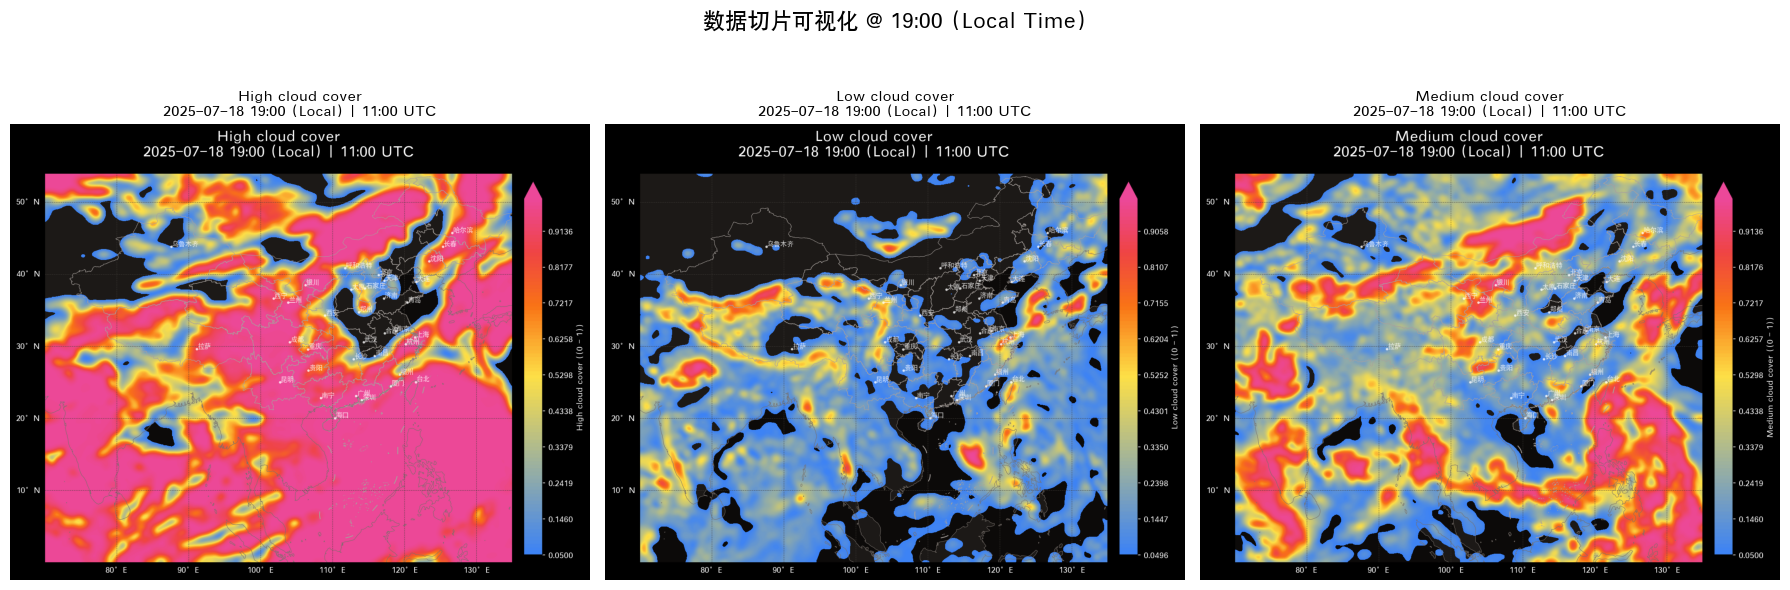

In [20]:
# --- 步骤三: 可视化所有生成的数据切片 ---

if not processed_files_by_time:
    print("❌ 没有可供可视化的数据切片。")
else:
    print("\n" + "="*80)
    print("===== 开始对所有数据切片进行可视化 =====")
    print("="*80)

    # 按时间排序进行遍历
    for time_str, file_paths in sorted(processed_files_by_time.items()):
        local_time_formatted = f"{time_str[:2]}:{time_str[2:]}"
        
        print(f"\n--- 正在为本地时间 {local_time_formatted} 生成并排地图 ---")
        
        generated_images = []
        image_titles = []
        
        # 遍历该时间点的所有变量文件 (hcc, mcc, lcc...)
        for file_path in sorted(file_paths, key=lambda p: p.name):
            try:
                data_slice = xr.open_dataarray(file_path)
                
                # 从元数据中恢复原始UTC时间用于标题
                utc_time_str = "N/A"
                if 'original_utc_time' in data_slice.attrs:
                    utc_time_obj = datetime.fromisoformat(data_slice.attrs['original_utc_time'])
                    utc_time_str = utc_time_obj.strftime('%H:%M UTC')

                map_title = (
                    f"{data_slice.attrs.get('long_name', data_slice.name)}\n"
                    f"{TARGET_LOCAL_DATE_STR} {local_time_formatted} (Local) | {utc_time_str}"
                )
                
                image_bytes = generate_map_from_grid(data_slice, map_title)
                
                if image_bytes:
                    generated_images.append(image_bytes)
                    image_titles.append(map_title)
                else:
                    print(f"  - ❌ {file_path.name} 地图生成失败。")

            except Exception as e:
                print(f"  - ❌ 处理文件 {file_path.name} 时出错: {e}")
        
        # --- 为当前时间点显示并排的地图 ---
        if generated_images:
            num_images = len(generated_images)
            fig, axes = plt.subplots(1, num_images, figsize=(6 * num_images, 6))
            if num_images == 1: axes = [axes]
            
            fig.suptitle(f"数据切片可视化 @ {local_time_formatted} (Local Time)", fontsize=16, y=1.02)
            
            for i, (img_bytes, title) in enumerate(zip(generated_images, image_titles)):
                img = plt.imread(io.BytesIO(img_bytes), format='png')
                axes[i].imshow(img)
                axes[i].set_title(title, fontsize=11)
                axes[i].axis('off')
            
            plt.tight_layout(rect=[0, 0, 1, 0.96]) # 调整布局为 suptitle 留出空间
            plt.show() # 显示当前时间点的并排图
        else:
            print("  - 未能为当前时间点生成任何地图。")